<a href="https://colab.research.google.com/github/NicoleRichards1998/FinRL/blob/master/Optimisation_DayTrading_FinRL_JSE_Singe_Stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Disclaimer: Nothing herein is financial advice, and NOT a recommendation to trade real money. Many platforms exist for simulated trading (paper trading) which can be used for building and developing the methods discussed. Please use common sense and always first consult a professional before trading or investing.

# Part 1: Install FinRL

In [ ]:
## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

In [ ]:
!pip install tensorboardX

In [ ]:
!pip uninstall -y pyarrow
!pip uninstall -y ray # clean removal of previous install, otherwise version number may cause pip not to upgrade

In [ ]:
!python -m pip install --upgrade pip

In [ ]:
!pip install tf-estimator-nightly==2.8.0.dev2021122109
!pip install -U https://s3-us-west-2.amazonaws.com/ray-wheels/latest/ray-2.0.0.dev0-cp37-cp37m-manylinux2014_x86_64.whl # minimal install
!pip install lz4

In [2]:
import gym
import numpy as np
from numpy import random as rd

class NoIndicatorsStockTradingEnv(gym.Env):
    def __init__(
        self,
        config,
        initial_account=1e6,
        gamma=0.99,
        turbulence_thresh=50000,
        min_stock_rate=0.1,
        max_stock=1e2,
        initial_capital=1e6,
        buy_cost_pct=1e-3,
        sell_cost_pct=1e-3,
        reward_scaling=2 ** -11,
        initial_stocks=None,
    ):
        price_ary = config["price_array"]
        #tech_ary = config["tech_array"]
        turbulence_ary = config["turbulence_array"]
        if_train = config["if_train"]
        self.price_ary = price_ary.astype(np.float32)
        #self.tech_ary = tech_ary.astype(np.float32)
        self.turbulence_ary = turbulence_ary

        #self.tech_ary = self.tech_ary * 2 ** -7
        self.turbulence_bool = (turbulence_ary > turbulence_thresh).astype(np.float32)
        self.turbulence_ary = (
            self.sigmoid_sign(turbulence_ary, turbulence_thresh) * 2 ** -5
        ).astype(np.float32)

        stock_dim = self.price_ary.shape[1]
        self.gamma = gamma
        self.max_stock = max_stock
        self.min_stock_rate = min_stock_rate
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.reward_scaling = reward_scaling
        self.initial_capital = initial_capital
        self.initial_stocks = (
            np.zeros(stock_dim, dtype=np.float32)
            if initial_stocks is None
            else initial_stocks
        )

        # reset()
        self.day = None
        self.amount = None
        self.stocks = None
        self.total_asset = None
        self.gamma_reward = None
        self.initial_total_asset = None
        
        self.sell_index = False

        # environment information
        self.env_name = "StockEnv"
        # self.state_dim = 1 + 2 + 2 * stock_dim + self.tech_ary.shape[1]
        # # amount + (turbulence, turbulence_bool) + (price, stock) * stock_dim + tech_dim
        self.state_dim = 1 + 2 + 3 * stock_dim
        # amount + (turbulence, turbulence_bool) + (price, stock) * stock_dim + tech_dim
        self.stocks_cd = None
        self.action_dim = stock_dim
        self.max_step = self.price_ary.shape[0] - 1
        self.if_train = if_train
        self.if_discrete = False
        self.target_return = 10.0
        self.episode_return = 0.0

        self.observation_space = gym.spaces.Box(
            low=-3000, high=3000, shape=(self.state_dim,), dtype=np.float32
        )
        self.action_space = gym.spaces.Box(
            low=-1, high=1, shape=(self.action_dim,), dtype=np.float32
        )

    def reset(self):
        self.day = 0
        price = self.price_ary[self.day]

        if self.if_train:
            self.stocks = (
                self.initial_stocks + rd.randint(0, 64, size=self.initial_stocks.shape)
            ).astype(np.float32)
            self.stocks_cool_down = np.zeros_like(self.stocks)
            self.amount = (
                self.initial_capital * rd.uniform(0.95, 1.05)
                - (self.stocks * price).sum()
            )
        else:
            self.stocks = self.initial_stocks.astype(np.float32)
            self.stocks_cool_down = np.zeros_like(self.stocks)
            self.amount = self.initial_capital

        self.total_asset = self.amount + (self.stocks * price).sum()
        self.initial_total_asset = self.total_asset
        self.gamma_reward = 0.0
        return self.get_state(price)  # state

    def step(self, actions):
        actions = (actions * self.max_stock).astype(int)

        self.day += 1
        price = self.price_ary[self.day]
        self.stocks_cool_down += 1
        sell_index = self.sell_index

        if self.turbulence_bool[self.day] == 0:
            min_action = int(self.max_stock * self.min_stock_rate)  # stock_cd
            for index in np.where(actions < -min_action)[0]:  # sell_index:
                if price[index] > 0:  # Sell only if current asset is > 0
                    sell_num_shares = min(self.stocks[index], -actions[index])
                    self.stocks[index] -= sell_num_shares
                    self.amount += (
                        price[index] * sell_num_shares * (1 - self.sell_cost_pct)
                    )
                    self.stocks_cool_down[index] = 0
                    sell_index = True
            for index in np.where(actions > min_action)[0]:  # buy_index:
                if (
                    price[index] > 0
                ):  # Buy only if the price is > 0 (no missing data in this particular date)
                    buy_num_shares = min(self.amount // price[index], actions[index])
                    self.stocks[index] += buy_num_shares
                    self.amount -= (
                        price[index] * buy_num_shares * (1 + self.buy_cost_pct)
                    )
                    self.stocks_cool_down[index] = 0

        else:  # sell all when turbulence
            self.amount += (self.stocks * price).sum() * (1 - self.sell_cost_pct)
            self.stocks[:] = 0
            self.stocks_cool_down[:] = 0

        state = self.get_state(price)
        total_asset = self.amount + (self.stocks * price).sum()
        real_reward = (total_asset - self.total_asset) * self.reward_scaling
        self.total_asset = total_asset

        # for my reward function
        
        #if sell_index == True:
        #  reward = real_reward
        #  sell_index = False
        #else:
        #  reward = int(0)
        #print('reward', reward)

        # for reward at end

        reward = int(0)

        # for OG reward function

        reward = (total_asset - self.total_asset) * self.reward_scaling

        # the rest

        self.gamma_reward = self.gamma_reward * self.gamma + real_reward
        done = self.day == self.max_step
        if done:
            reward = self.gamma_reward
            self.episode_return = total_asset / self.initial_total_asset

        return state, reward, done, dict()

    def get_state(self, price):
        amount = np.array(self.amount * (2 ** -12), dtype=np.float32)
        scale = np.array(2 ** -6, dtype=np.float32)
        return np.hstack(
            (
                amount,
                self.turbulence_ary[self.day],
                self.turbulence_bool[self.day],
                price * scale,
                self.stocks * scale,
                self.stocks_cool_down,
            )
        )  # state.astype(np.float32)

    @staticmethod
    def sigmoid_sign(ary, thresh):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x * np.e)) - 0.5

        return sigmoid(ary / thresh) * thresh

In [1]:
!pip install git+https://github.com/NicoleRichards1998/FinRL.git
!pip install 'HEBO>=0.2.0'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/NicoleRichards1998/FinRL.git to /tmp/pip-req-build-diksrc4r
  Running command git clone -q https://github.com/NicoleRichards1998/FinRL.git /tmp/pip-req-build-diksrc4r
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-qc3zvni6/pyfolio_093b97b111884b1181160c002e1d4579
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-qc3zvni6/pyfolio_093b97b111884b1181160c002e1d4579
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-qc3zvni6/elegantrl_5df7d090c5544ef7991538ed7f8d3cd0
  Running command git clone -q https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-qc3zvni6/elegantrl_5df7d090c5544ef7991538ed7f8d3cd0
     |████████████████████████████████| 234 kB 7.8 MB/s 
     |████████████████████████████████| 177 kB 44.7 MB/s 
     |██████████████████████████████

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 106 kB 5.2 MB/s 
     |████████████████████████████████| 959 kB 28.9 MB/s 
     |████████████████████████████████| 76.6 MB 1.2 MB/s 
     |████████████████████████████████| 310 kB 66.2 MB/s 
     |████████████████████████████████| 2.5 MB 48.4 MB/s 
     |████████████████████████████████| 71 kB 10.5 MB/s 
     |████████████████████████████████| 239 kB 67.0 MB/s 
  Created wheel for GPy: filename=GPy-1.10.0-cp37-cp37m-linux_x86_64.whl size=2565149 sha256=27eba3146b8053b9644444b45011adc3595da77b013ec0cf6f13534770bdec67
  Stored in directory: /root/.cache/pip/wheels/f7/18/28/dd1ce0192a81b71a3b086fd952511d088b21e8359ea496860a
  Created wheel for gpytorch: filename=gpytorch-1.6.0-py2.py3-none-any.whl size=509889 sha256=ca5b288c4ae6b0e47d8341d83868acb8bbdc0df09243c31ac07296abf2365a2a
  Stored in directory: /root/.cache/pip/wheels/66/b5/89/34c06ad393a6feb72

In [ ]:
print("Setting up colab environment")
!pip uninstall -y -q pyarrow
!pip install -q -U ray[tune]
!pip install -q ray[debug]

# A hack to force the runtime to restart, needed to include the above dependencies.
print("Done installing! Restarting via forced crash (this is not an issue).")
import os
os._exit(0)

Setting up colab environment


## Import related modules

In [1]:
#from finrl.finrl_meta.env_stock_trading.env_stocktrading_np import EndRewardStockTradingEnv as StockTradingEnv1
#from finrl.finrl_meta.env_stock_trading.env_stocktrading_np import StockTradingEnv
#from finrl.finrl_meta.env_stock_trading.env_stocktrading_np import ChangedStockTradingEnv as StockTradingEnv2

from finrl.finrl_meta.env_stock_trading.env_stock_papertrading import AlpacaPaperTrading
from finrl.finrl_meta.data_processor import DataProcessor
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from finrl.agents.rllib.models import DRLAgent as DRLAgent_rllib

import numpy as np
import pandas as pd
import ray

from ray.rllib.agents.a3c import a2c
from ray.rllib.agents.ddpg import ddpg, td3
from ray.rllib.agents.ppo import ppo
from ray.rllib.agents.ppo.ppo import PPOTrainer
from ray.rllib.agents.ddpg import DDPGTrainer
from ray.rllib.agents.a3c import A2CTrainer
from ray.rllib.agents.sac import sac
from ray.tune.logger import (
    CSVLoggerCallback,
    JsonLoggerCallback,
    JsonLogger,
    CSVLogger,
    TBXLoggerCallback,
    TBXLogger,
    UnifiedLogger
)
from ray.tune.logger import pretty_print

from ray.tune.logger import pretty_print
from ray import tune
from ray.tune.suggest import ConcurrencyLimiter
from ray.tune.schedulers import AsyncHyperBandScheduler, PopulationBasedTraining
from ray.tune.suggest.hebo import HEBOSearch
from ray.tune.suggest.optuna import OptunaSearch

from google.colab import files
from datetime import date, timedelta, datetime

from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.core.arrays import string_

import pytz
import exchange_calendars as tc

from stockstats import StockDataFrame as Sdf

import psutil
import ray
ray._private.utils.get_system_memory = lambda: psutil.virtual_memory().total

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


## Set variables

In [3]:
model_algorithm = 'ppo'
starting_capital = 1e6

Number_Train_Days = 10

Number_Test_Days = 9

In [4]:
JSEIndexes = [ 'ACL' ]

In [ ]:
JSEIndexes = [ 
  'SNH',
  'WHL',
 'FSR',
 'RMH',
 'BLU',
 'SSW',
 'LAB',
 'TGA',
 'SPG',
 'PPC',
 'OMU',
 'GFI',
 'NPK',
 'HAR',
 'LHC',
 'TSG',
 'ACL',
 'PPH',
 'SBK',
 'PPE',
 'CML',
 'MRF',
 'MTN',
 'AVI',
 'SOL',
 'EXX',
 'TRU',
 'NED',
 'TCP',
 'WSL'
 ]

In [5]:
ticker_list = JSEIndexes
action_dim = len(ticker_list)

INDICATORS = ['macd', 'boll_ub', 'boll_lb', 'rsi_30', 'dx_30', 'close_30_sma', 'close_60_sma']
tech_indicator_list = INDICATORS
env = NoIndicatorsStockTradingEnv

# amount + (turbulence, turbulence_bool) + (price, shares, cd (holding time)) * stock_dim + tech_dim
#state_dim = 1 + 2 + 3 * action_dim + len(INDICATORS) * action_dim
state_dim = 1 + 2 + 3 * action_dim

episodes_per_day = 150
tr_batch_size = episodes_per_day*480

rllib_params = {"lr": 5e-5, "train_batch_size": tr_batch_size, "gamma": 0.99}

MODELS = {"a2c": a2c, "ddpg": ddpg, "td3": td3, "sac": sac, "ppo": ppo}

In [ ]:
action_dim

1

# Part 2: Train the agent

## Train

In [6]:
%load_ext tensorboard

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
%cd /content/drive/MyDrive/csvfiles/

/content/drive/MyDrive/csvfiles


In [9]:
data_df = pd.read_csv("JSE_Minute_Data_With_Turbulance_Indicator.csv")

In [10]:
df = data_df.copy()
df = df.sort_values(by=["tic", "date"])
x = 9620
dic_tickers = {}

for i in range(30):

  dic_tickers[i] = df.iloc[(i*x):((i+1)*x),]

In [ ]:
dic_tickers[0]

In [11]:
trading_days = pd.date_range(start = '02/28/22', end = '03/25/22')

trading_days_List = trading_days[0:].strftime('%m/%d/%y').to_numpy().tolist()
count = 0
delete_number = 0
while count < 26:
    if (trading_days[count].weekday()>=5):
      del trading_days_List[delete_number]
      delete_number = delete_number - 1
    count = count + 1
    delete_number = delete_number + 1 

In [ ]:
df = dic_tickers[0].copy()
df

In [12]:
x = 481
df = dic_tickers[0].copy()
df = df.reset_index(drop=True)
dic = {}

for j in range(len(df)):
    df['date'][j] = datetime.strptime(df['date'][j], '%m/%d/%y %H:%M')
df = df.sort_values(by=["date"])

for i in range(20):
  
  dic[i] = df.iloc[(i*x):((i+1)*x),]
  dic[i] = dic[i].sort_values(by=["tic", "date"])
  dic[i] = dic[i].reset_index(drop=True)
  #for j in range(len(dic[i])):
  #  dic[i]['date'][j] = datetime.strptime(dic[i]['date'][j], '%m/%d/%y %H:%M')
  dic[i] = dic[i].sort_values(by=["date"])

del dic[15]
dic = dict(enumerate(dic[x] for x in sorted(dic)))

In [ ]:
dic[18]

In [ ]:
x = 14430
df = data_df.copy()
dic = {}

for i in range(20):

  dic[i] = df.iloc[(i*x):((i+1)*x),]


In [13]:
def df_to_array(df, if_vix):
        df = df.copy()
        unique_ticker = df.tic.unique()
        if_first_time = True
        for tic in unique_ticker:
            if if_first_time:
                price_array = df[df.tic == tic][["close"]].values
                tech_array = df[df.tic == tic][tech_indicator_list].values
                if if_vix:
                    turbulence_array = df[df.tic == tic]["VIXY"].values
                else:
                    turbulence_array = df[df.tic == tic]["turbulence"].values
                if_first_time = False
            else:
                price_array = np.hstack(
                    [price_array, df[df.tic == tic][["close"]].values]
                )
                tech_array = np.hstack(
                    [tech_array, df[df.tic == tic][tech_indicator_list].values]
                )
        print("Successfully transformed into array")
        return price_array, tech_array, turbulence_array

In [14]:
def get_config_Train(dic, Number_Days):  

    env_config = []

    for index in range(Number_Days):

      print(index)

      price_array, tech_array, turbulence_array = df_to_array(dic[index], False)

      config = {
          "price_array": price_array,
          "tech_array": tech_array,
          "turbulence_array": turbulence_array,
          "if_train": True,
      }

      env_config.append(config)

    return env_config

In [15]:
train_env_config = get_config_Train(dic, Number_Train_Days)

0
Successfully transformed into array
1
Successfully transformed into array
2
Successfully transformed into array
3
Successfully transformed into array
4
Successfully transformed into array
5
Successfully transformed into array
6
Successfully transformed into array
7
Successfully transformed into array
8
Successfully transformed into array
9
Successfully transformed into array


In [16]:
from typing import Dict

import json

import os
import tempfile

from ray.tune.utils.util import SafeFallbackEncoder
from ray.tune.logger import Logger

EXPR_TRACK_FILE = "episode_tracking.json"
CUSTOM_RESULTS_DIR = '/content/drive/MyDrive/TrainingData'
DEFAULT_LOGGERS = (JsonLogger, CSVLogger, TBXLogger)

class CustomLogger(Logger):
    """Logs custom results in json format."""

    def _init(self):
        self.update_config(self.config)
        logger_config = self.config.get("logger_config")
        filename = EXPR_TRACK_FILE
        if logger_config:
            filename = logger_config.get("filename") or filename
        local_file = os.path.join(self.logdir, filename)
        self.local_out = open(local_file, "a")

    def on_result(self, result: Dict):
        tracking_data = result["episode_media"]
        if not tracking_data:
            return
        json.dump(tracking_data, self, cls=SafeFallbackEncoder)
        self.write("\n")
        self.local_out.flush()

    def write(self, b):
        self.local_out.write(b)

    def flush(self):
        if not self.local_out.closed:
            self.local_out.flush()

    def close(self):
        self.local_out.close()

    def update_config(self, config: Dict):
        self.config = config

def custom_logger_creator(config):
    """Creates a Unified logger with a default logdir prefix
    containing the agent name and the env id
    """
    timestr = datetime.today().strftime("%Y-%m-%d_%H-%M-%S")
    logdir_prefix = "{}_{}_{}".format("PPO", "HSP", timestr)
    if not os.path.exists(CUSTOM_RESULTS_DIR):
        os.makedirs(CUSTOM_RESULTS_DIR)
    logdir = tempfile.mkdtemp(
        prefix=logdir_prefix, dir=CUSTOM_RESULTS_DIR)
    loggers = list(DEFAULT_LOGGERS)
    loggers.append(CustomLogger)
    return UnifiedLogger(config, logdir, loggers=loggers)

In [17]:
def training(
        env_config,
        drl_lib,
        env,
        model_name,
        init_ray=True,
        **kwargs
):
   
    env_instance = env(config=env_config)

    print(env_instance)

    rllib_params = kwargs.get("rllib_params")
    
    agent_rllib = DRLAgent_rllib(
            env=env,
            price_array=env_config['price_array'],
            tech_array=env_config['tech_array'],
            turbulence_array=env_config['turbulence_array'],
        )
    
    print(agent_rllib)

    model, model_config = agent_rllib.get_model(model_name)

    print('got model_config')

    model_config["lr"] = rllib_params["lr"]
    model_config["train_batch_size"] = rllib_params["train_batch_size"]
    model_config["gamma"] = rllib_params["gamma"]

    #model_config["output"] = "/content/drive/MyDrive/csvfiles" 
    #model_config["local_dir"] = "./trained_models"
    #model_config["reuse_actors"] = True
    #model_config["callbacks"] = [TBXLoggerCallback()]

    model_config['framework'] = "tf2"
    model_config['num_workers'] = 4
    model_config['num_cpus_per_worker'] = 0 
    model_config['num_gpus'] = 1
    model_config["eager_tracing"] = True

    model_config["model"]["use_lstm"] = True
    model_config["model"]["lstm_cell_size"] = 256
    model_config["model"]["lstm_use_prev_action"] = True
    model_config["model"]["lstm_use_prev_reward"] = True

    if model_name not in MODELS:
            raise NotImplementedError("NotImplementedError")
    if init_ray:
            ray.init(
                ignore_reinit_error=True
            )  # Other Ray APIs will not work until `ray.init()` is called.
    print('ray initialised')

    if model_name == "ppo":
            trainer = model.PPOTrainer(env=env, logger_creator=custom_logger_creator, config=model_config)
    elif model_name == "a2c":
            trainer = model.A2CTrainer(env=env, config=model_config)
    elif model_name == "ddpg":
            trainer = model.DDPGTrainer(env=env, config=model_config)
    elif model_name == "td3":
            trainer = model.TD3Trainer(env=env, config=model_config)
    elif model_name == "sac":
            trainer = model.SACTrainer(env=env, config=model_config)

    print('got trainer')
    return(trainer)

In [18]:
def train_model(
        total_episodes,
        env_config_list,
        drl_lib,
        env,
        model_name,
        init_ray=True,
        **kwargs
):

        s = "{:3d} reward {:6.2f}/{:6.2f}/{:6.2f} len {:6.2f} saved {}"

        trainer = training(
                        env_config = env_config_list[0],
                        drl_lib='rllib', 
                        env=env,
                        model_name = model_algorithm, 
                        init_ray=True,
                        rllib_params = rllib_params)
        #trainer.restore('/tmp/rllib_checkpoint/checkpoint_000010/checkpoint-10')
        result = trainer.train()
        print(pretty_print(result))
            
        file_name = trainer.save("/tmp/rllib_checkpoint")

        print(s.format(
              1,
              result["episode_reward_min"],
              result["episode_reward_mean"],
              result["episode_reward_max"],
              result["episode_len_mean"],
              file_name
            ))

        ray.shutdown()

        for episode in range(total_episodes-1):
            trainer = training(
                        env_config = env_config_list[episode+1],
                        drl_lib='rllib',
                        env=env,
                        model_name = model_algorithm, 
                        init_ray=True,
                        rllib_params = rllib_params)
                        
            trainer.restore(file_name)
            result = trainer.train()
            print(pretty_print(result))
            
            file_name = trainer.save("/tmp/rllib_checkpoint")

            print(s.format(
              episode + 2,
              result["episode_reward_min"],
              result["episode_reward_mean"],
              result["episode_reward_max"],
              result["episode_len_mean"],
              file_name
            ))

            ray.shutdown()
  
        return file_name

In [ ]:
trainer.save("/content/drive/MyDrive/TrainingData")

In [ ]:
ray.shutdown()

In [ ]:
checkpoint_path = train_model(
      total_episodes = len(train_env_config),
      env_config_list = train_env_config,
      drl_lib='rllib', 
      env=env,
      model_name = model_algorithm, 
      rllib_params = rllib_params)

## Tune

In [19]:
!pip install comet_ml --quiet

     |████████████████████████████████| 350 kB 5.1 MB/s 
     |████████████████████████████████| 552 kB 51.9 MB/s 
     |████████████████████████████████| 54 kB 2.9 MB/s 


In [20]:
import comet_ml
comet_ml.init(project_name='comet-ray')

In [21]:
day = 0

In [23]:
def sample_ppo_params():
  return {
      "clip_param": tune.choice([ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6 ]),
      "lambda": tune.loguniform(0.9, 1),
      "lr": tune.loguniform(5e-6, 0.003),
      "gamma": tune.loguniform(0.9, 0.9997),
      "train_batch_size": 960
  }

def sample_ddpg_params():
  
  return {
  "critic_lr": tune.loguniform(1e-3, 1e-4),
  "actor_lr": tune.loguniform(1e-3, 1e-5),
  "tau": tune.loguniform(0, 1e-3),
  "train_batch_size": 4800
  }

def sample_a2c_params():
  
  return{
       "lambda": tune.choice([0.1,0.3,0.5,0.7,0.9,1.0]),
      "entropy_coeff": tune.loguniform(0.00000001, 0.1),
      "lr": tune.loguniform(1e-5, 1),
      "gamma": tune.loguniform(0.9, 0.9997),
      "train_batch_size": 4800   
  } 

from ray.tune.registry import register_env
from ray.tune.integration.comet import CometLoggerCallback
from ray.tune.logger import (
    CSVLoggerCallback,
    JsonLoggerCallback,
    JsonLogger,
    CSVLogger,
    TBXLoggerCallback,
    TBXLogger,
)

env_name = 'StockTrading_train_env'
register_env(env_name, lambda config: env(train_env_config[day]))

MODEL_TRAINER = {'a2c':A2CTrainer,'ppo':PPOTrainer,'ddpg':DDPGTrainer}

if model_algorithm == "ddpg":
    sample_hyperparameters = sample_ddpg_params()
elif model_algorithm == "ppo":
  sample_hyperparameters = sample_ppo_params()
elif model_algorithm == "a2c":
  sample_hyperparameters = sample_a2c_params()
  
def run_optuna_tune():

  #bayesopt = BayesOptSearch(metric="episode_reward_mean", mode="max")
  #hebo = HEBOSearch()
  #re_search_alg = Repeater(search_alg, repeat=10)

  #algo = OptunaSearch()
  #algo = ConcurrencyLimiter(algo,max_concurrent=4)
  #scheduler = AsyncHyperBandScheduler(time_attr='training_iteration',
	#				metric='episode_reward_mean',
  #        mode='max'
	#			grace_period=10)
  #scheduler=pbt
  #num_samples = 10
  #training_iterations = 50

  # maximum number of concurrent trials
  max_concurrent = 8

  algo = HEBOSearch(
        # space = space, # If you want to set the space
        #points_to_evaluate=previously_run_params,
        #evaluated_rewards=known_rewards,
        random_state_seed=123,  # for reproducibility
        max_concurrent=max_concurrent,
    )

  scheduler = AsyncHyperBandScheduler()

  training_iterations = 100
  num_samples = 15

  analysis = tune.run(
        MODEL_TRAINER[model_algorithm],
        metric="episode_reward_mean", #The metric to optimize for tuning
        mode="max", #Maximize the metric
        #name='B1',
        search_alg=algo,
        scheduler=scheduler,
        num_samples=num_samples,
        keep_checkpoints_num = num_samples,
        stop = {'training_iteration':training_iterations},
        checkpoint_score_attr ='episode_reward_mean',#Only store keep_checkpoints_num trials based on this score
        checkpoint_freq=training_iterations,
        verbose=1,
        local_dir="./tuned_models",#Saving tensorboard plots
        callbacks=[
          CometLoggerCallback(
            tags=["try1"],
          ),
          TBXLoggerCallback()
        ],
        raise_on_failed_trial=False,
        #keep_checkpoints_num = num_samples, 
        #checkpoint_score_attr ='episode_reward_mean',#Only store keep_checkpoints_num trials based on this score
        #checkpoint_freq=training_iterations,
        #resources_per_trial={'gpu':1,'cpu':1},
        config = {
                **sample_hyperparameters,
                'env':'StockTrading_train_env',
                'framework':'tf2',
                "eager_tracing" : True,
                "num_workers": 1,
                # Total GPU usage: num_gpus (trainer proc) + num_gpus_per_worker (workers)
                #"num_gpus_per_worker": 0.25,
                # this corresponds to the number of learner GPUs used,
                # not the total used for the environments/rollouts
                "num_gpus": 1,
                "num_envs_per_worker": 1,
                #"callbacks": LoggingCallbacks,
                "model":{
                    "use_lstm": True,
                    "lstm_cell_size": 256,
                    "lstm_use_prev_action": True,
                    "lstm_use_prev_reward": True,
                  }
                },
  )


  print("Best hyperparameter: ", analysis.best_config)
  #print("Training: ", analysis.trails)
  return analysis

In [38]:
ray.shutdown()

In [ ]:
analysis = run_optuna_tune()

In [1]:
%tensorboard --logdir ~/ray_results/tuned_models

UsageError: Line magic function `%tensorboard` not found.


In [ ]:
analysis.dataframe()

In [29]:
# Plot training results
import matplotlib.pyplot as plt
import pandas as pd
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
df = analysis.dataframe()
# Get column for total loss, policy loss, and value loss
tl_col = [i for i, j in enumerate(df.columns)
          if 'total_loss' in j][0]
pl_col = [i for i, j in enumerate(df.columns)
          if 'policy_loss' in j][0]
vl_col = [i for i, j in enumerate(df.columns)
          if 'vf_loss' in j][0]
labels = []
fig, ax = plt.subplots(2, 2, figsize=(15, 15), sharex=True)
for i, path in df['logdir'].iteritems():
    data = pd.read_csv(path + '/progress.csv')
    # Get labels for legend
    lr = data['experiment_tag'][0].split('=')[1].split(',')[0]
    layers = data['experiment_tag'][0].split('=')[-1]
    labels.append('LR={}; Shared Layers={}'.format(lr, layers))
    
    ax[0, 0].plot(data['timesteps_total'], 
            data['episode_reward_mean'], c=colors[i],
            label=labels[-1])
    
    ax[0, 1].plot(data['timesteps_total'], 
           data.iloc[:, tl_col], c=colors[i],
           label=labels[-1])
    
    ax[1, 0].plot(data['timesteps_total'], 
               data.iloc[:, pl_col], c=colors[i],
               label=labels[-1])
    
    
    ax[1, 1].plot(data['timesteps_total'], 
               data.iloc[:, vl_col], c=colors[i],
               label=labels[-1])
ax[0, 0].set_ylabel('Mean Rewards')
ax[0, 0].set_title('Training Rewards by Time Step')
ax[0, 0].legend(labels=labels, loc='upper center',
        ncol=3, bbox_to_anchor=[0.75, 1.2])
ax[0, 1].set_title('Total Loss by Time Step')
ax[0, 1].set_ylabel('Total Loss')
ax[0, 1].set_xlabel('Training Episodes')
ax[1, 0].set_title('Policy Loss by Time Step')
ax[1, 0].set_ylabel('Policy Loss')
ax[1, 0].set_xlabel('Time Step')
ax[1, 1].set_title('Value Loss by Time Step')
ax[1, 1].set_ylabel('Value Loss')
ax[1, 1].set_xlabel('Time Step')
plt.show()

UsageError: Line magic function `%export` not found.


In [30]:
best_logdir = {}
best_checkpoint = {}
best_config = {}

best_logdir[day] = analysis.get_best_logdir(metric='episode_reward_mean',mode='max')
best_checkpoint[day] = analysis.best_checkpoint
best_config[day] = analysis.best_config 

2022-05-30 09:08:25,026	ERROR experiment_analysis.py:450 -- No checkpoints have been found for trial PPOTrainer_StockTrading_train_env_49b26d7c.


## Graphs

In [ ]:
def stringToList(string):
    listRes = list(string.split(", "))
    return listRes

def fixString(reward_list):
  float_list = reward_list.replace('[', '')
  float_list = float_list.replace(']', '')
  float_list = stringToList(float_list)
  float_list = [float(x) for x in float_list]
  return float_list

In [ ]:
run_through_A8 = {}
run_through_A9 = {}
run_through_A10 = {}

In [ ]:
# my reward function, with indicators

In [ ]:
%cd /content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-23_07-03-30dq755ny0/
training_data1 = pd.read_csv('progress.csv')
episode_reward_list1 = fixString(training_data1['hist_stats/episode_reward'][0])
run_through_A8[0] = episode_reward_list1

%cd /content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-23_07-18-03l5_lemz3/
training_data2 = pd.read_csv('progress.csv')
episode_reward_list2 = fixString(training_data2['hist_stats/episode_reward'][0])
run_through_A8[1] = episode_reward_list2

%cd /content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-23_07-33-58xpod9b1y/
training_data3 = pd.read_csv('progress.csv')
episode_reward_list3 = fixString(training_data3['hist_stats/episode_reward'][0])
run_through_A8[2] = episode_reward_list3

%cd /content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-23_07-52-17pn0i8kao/
training_data4 = pd.read_csv('progress.csv')
episode_reward_list4 = fixString(training_data4['hist_stats/episode_reward'][0])
run_through_A8[3] = episode_reward_list4

%cd /content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-23_08-14-33odc3zd0o/
training_data5 = pd.read_csv('progress.csv')
episode_reward_list5 = fixString(training_data5['hist_stats/episode_reward'][0])
run_through_A8[4] = episode_reward_list5

%cd /content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-23_08-45-482vydbczz/
training_data6 = pd.read_csv('progress.csv')
episode_reward_list6 = fixString(training_data6['hist_stats/episode_reward'][0])
run_through_A8[5] = episode_reward_list6

%cd /content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-23_09-25-490fcpereh/
training_data7 = pd.read_csv('progress.csv')
episode_reward_list7 = fixString(training_data7['hist_stats/episode_reward'][0])
run_through_A8[6] = episode_reward_list7

%cd /content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-23_10-11-272nuwnbjr/
training_data8 = pd.read_csv('progress.csv')
episode_reward_list8 = fixString(training_data8['hist_stats/episode_reward'][0])
run_through_A8[7] = episode_reward_list8

%cd /content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-23_11-17-16fht581gt/
training_data9 = pd.read_csv('progress.csv')
episode_reward_list9 = fixString(training_data9['hist_stats/episode_reward'][0])
run_through_A8[8] = episode_reward_list9

%cd /content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-23_12-41-02y6jrfiq4/
training_data10 = pd.read_csv('progress.csv')
episode_reward_list10 = fixString(training_data10['hist_stats/episode_reward'][0])
run_through_A8[9] = episode_reward_list10

/content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-23_07-03-30dq755ny0
/content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-23_07-18-03l5_lemz3
/content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-23_07-33-58xpod9b1y
/content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-23_07-52-17pn0i8kao
/content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-23_08-14-33odc3zd0o
/content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-23_08-45-482vydbczz
/content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-23_09-25-490fcpereh
/content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-23_10-11-272nuwnbjr
/content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-23_11-17-16fht581gt
/content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-23_12-41-02y6jrfiq4


In [ ]:
# reward at end, without indicators

In [ ]:
%cd /content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-24_04-55-19v4wjb1zf/
training_data1 = pd.read_csv('progress.csv')
episode_reward_list1 = fixString(training_data1['hist_stats/episode_reward'][0])
run_through_A10[0] = episode_reward_list1

%cd /content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-24_05-09-57vz3l0_09/
training_data1 = pd.read_csv('progress.csv')
episode_reward_list2 = fixString(training_data1['hist_stats/episode_reward'][0])
run_through_A10[1] = episode_reward_list2

%cd /content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-24_05-26-13tzkx22bn/
training_data1 = pd.read_csv('progress.csv')
episode_reward_list3 = fixString(training_data1['hist_stats/episode_reward'][0])
run_through_A10[2] = episode_reward_list3

%cd /content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-24_05-44-29dqbht7_7/
training_data1 = pd.read_csv('progress.csv')
episode_reward_list4 = fixString(training_data1['hist_stats/episode_reward'][0])
run_through_A10[3] = episode_reward_list4

%cd /content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-24_06-05-2544o46ack/
training_data1 = pd.read_csv('progress.csv')
episode_reward_list5 = fixString(training_data1['hist_stats/episode_reward'][0])
run_through_A10[4] = episode_reward_list5

%cd /content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-24_06-29-2995_ulgnl/
training_data1 = pd.read_csv('progress.csv')
episode_reward_list6 = fixString(training_data1['hist_stats/episode_reward'][0])
run_through_A10[5] = episode_reward_list6

%cd /content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-24_06-58-13aw79hsag/
training_data1 = pd.read_csv('progress.csv')
episode_reward_list7 = fixString(training_data1['hist_stats/episode_reward'][0])
run_through_A10[6] = episode_reward_list7

%cd /content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-24_07-32-02ibufhbt4/
training_data1 = pd.read_csv('progress.csv')
episode_reward_list8 = fixString(training_data1['hist_stats/episode_reward'][0])
run_through_A10[7] = episode_reward_list8

%cd /content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-24_08-11-59oug380cw/
training_data1 = pd.read_csv('progress.csv')
episode_reward_list9 = fixString(training_data1['hist_stats/episode_reward'][0])
run_through_A10[8] = episode_reward_list9

%cd /content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-24_09-04-45lwwyfl0b/
training_data1 = pd.read_csv('progress.csv')
episode_reward_list10 = fixString(training_data1['hist_stats/episode_reward'][0])
run_through_A10[9] = episode_reward_list10

/content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-24_04-55-19v4wjb1zf
/content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-24_05-09-57vz3l0_09
/content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-24_05-26-13tzkx22bn
/content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-24_05-44-29dqbht7_7
/content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-24_06-05-2544o46ack
/content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-24_06-29-2995_ulgnl
/content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-24_06-58-13aw79hsag
/content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-24_07-32-02ibufhbt4
/content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-24_08-11-59oug380cw
/content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-24_09-04-45lwwyfl0b


In [ ]:
# OG reward function, without indicators

In [ ]:
%cd /content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-26_05-51-43pj0jbdog/
training_data1 = pd.read_csv('progress.csv')
episode_reward_list10 = fixString(training_data1['hist_stats/episode_reward'][0])
run_through_A9[0] = episode_reward_list10

%cd /content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-26_06-07-248jwldcn6/
training_data1 = pd.read_csv('progress.csv')
episode_reward_list9 = fixString(training_data1['hist_stats/episode_reward'][0])
run_through_A9[1] = episode_reward_list9

%cd /content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-26_06-23-57ent7pctf/
training_data1 = pd.read_csv('progress.csv')
episode_reward_list8 = fixString(training_data1['hist_stats/episode_reward'][0])
run_through_A9[2] = episode_reward_list8

%cd /content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-26_06-42-50wj8ltht1/
training_data1 = pd.read_csv('progress.csv')
episode_reward_list7 = fixString(training_data1['hist_stats/episode_reward'][0])
run_through_A9[3] = episode_reward_list7

%cd /content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-26_07-04-1096llm5o3/
training_data1 = pd.read_csv('progress.csv')
episode_reward_list6 = fixString(training_data1['hist_stats/episode_reward'][0])
run_through_A9[4] = episode_reward_list6

%cd /content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-26_07-29-26pw34d0ll/
training_data1 = pd.read_csv('progress.csv')
episode_reward_list5 = fixString(training_data1['hist_stats/episode_reward'][0])
run_through_A9[5] = episode_reward_list5

%cd /content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-26_07-58-048e4vy398/
training_data1 = pd.read_csv('progress.csv')
episode_reward_list4 = fixString(training_data1['hist_stats/episode_reward'][0])
run_through_A9[6] = episode_reward_list4

%cd /content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-26_08-31-484zn7gukc/
training_data1 = pd.read_csv('progress.csv')
episode_reward_list3 = fixString(training_data1['hist_stats/episode_reward'][0])
run_through_A9[7] = episode_reward_list3

%cd /content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-26_09-11-28w32ak2dc/
training_data1 = pd.read_csv('progress.csv')
episode_reward_list2 = fixString(training_data1['hist_stats/episode_reward'][0])
run_through_A9[8] = episode_reward_list2

%cd /content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-26_10-00-52osq_87j8/
training_data1 = pd.read_csv('progress.csv')
episode_reward_list1 = fixString(training_data1['hist_stats/episode_reward'][0])
run_through_A9[9] = episode_reward_list1

/content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-26_05-51-43pj0jbdog
/content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-26_06-07-248jwldcn6
/content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-26_06-23-57ent7pctf
/content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-26_06-42-50wj8ltht1
/content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-26_07-04-1096llm5o3
/content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-26_07-29-26pw34d0ll
/content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-26_07-58-048e4vy398
/content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-26_08-31-484zn7gukc
/content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-26_09-11-28w32ak2dc
/content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-26_10-00-52osq_87j8


In [ ]:
def average_of_list(data):
  av_list = []
  for i in range(episodes_per_day):
    sum = 0
    for index in range(10):
      sum = sum + dic[index][i]
    av = sum / 10
    av_list.append(av)
  return av_list

In [ ]:
len(run_through_A9[0])

148

In [ ]:
data = run_through_A8.copy()
av_list8 = []
for i in range(episodes_per_day-2):
  sum = 0
  for index in range(10):
    sum = sum + data[index][i]
    #print(sum)
  av = sum / 10
  av_list8.append(av)
print(av_list8)

[-5.575246970359968, -5.91094360291192, -5.456433532916211, -5.188679351061398, -5.425785784757431, -5.093769187522575, -6.476435377123062, -5.653635137242369, -5.4114566886598245, -3.9149486687080794, -6.764498391092225, -6.546214829398528, -5.595691281982541, -6.342208562208324, -7.0859580910853, -5.623096662712976, -5.7094922703896005, -4.870415992844967, -4.761390673980989, -5.10702523367373, -5.4347576374845925, -5.049092976001594, -7.356941313045854, -5.819738192782504, -6.277878834292653, -5.682637805455601, -4.47944470118214, -4.860446972307589, -6.7599018997828555, -5.482704977563238, -6.486038479746298, -6.867616224267216, -6.055945462929114, -4.18588274055942, -4.907212456768766, -6.25663506335682, -5.9692715752624625, -4.662587077586691, -6.154316571745726, -7.152079323580443, -6.288574065390807, -4.6528032944896065, -6.234910051035886, -4.2928709725100855, -7.400482395975667, -6.502460613809156, -5.684558396677746, -5.4343621432127565, -5.693631265546105, -6.05939502436795

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

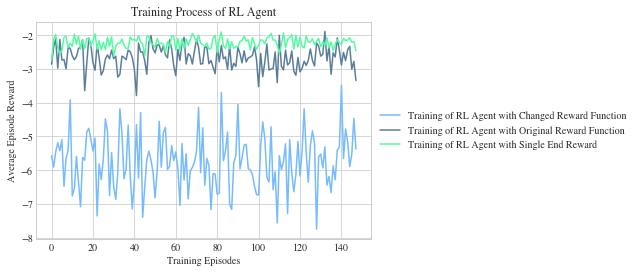

In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
 
x = list(range(episodes_per_day-2))
y1 = av_list8
y2 = av_list9
y3 = av_list10

fig = plt.figure(1)

plt.plot(x, y1, 'xkcd:sky blue', label = "Training of RL Agent with Changed Reward Function") 
plt.plot(x, y2, 'xkcd:steel blue', label = "Training of RL Agent with Original Reward Function")
plt.plot(x, y3, 'xkcd:sea green', label = "Training of RL Agent with Single End Reward")
    
# naming the x axis 
plt.xlabel('Training Episodes') 
# naming the y axis 
plt.ylabel('Average Episode Reward') 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

header = "Training Process of RL Agent"
plt.title(header) 
    
filename = header + ".png"
#plt.savefig(filename, dpi=300)
fig.savefig(filename, dpi=300, bbox_inches='tight')
files.download(filename) 

# function to show the plot 
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

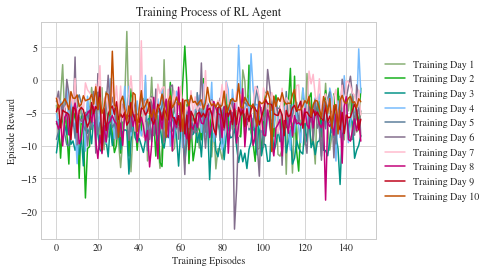

In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
 
x = list(range(episodes_per_day-2))
y1 = episode_reward_list1
y2 = episode_reward_list2
y3 = episode_reward_list3
y4 = episode_reward_list4
y5 = episode_reward_list5
y6 = episode_reward_list6
y7 = episode_reward_list7
y8 = episode_reward_list8
y9 = episode_reward_list9
y10 = episode_reward_list10

fig = plt.figure(1)

plt.plot(x, y1, 'xkcd:sage', label = "Training Day 1") 
plt.plot(x, y2, 'xkcd:green', label = "Training Day 2")
plt.plot(x, y3, 'xkcd:teal', label = "Training Day 3")
plt.plot(x, y4, 'xkcd:sky blue', label = "Training Day 4") 
plt.plot(x, y5, 'xkcd:steel blue', label = "Training Day 5")
plt.plot(x, y6, 'xkcd:grey purple', label = "Training Day 6")
plt.plot(x, y7, 'xkcd:pastel pink', label = "Training Day 7") 
plt.plot(x, y8, 'xkcd:magenta', label = "Training Day 8")
plt.plot(x, y9, 'xkcd:scarlet', label = "Training Day 9")
plt.plot(x, y10, 'xkcd:burnt orange', label = "Training Day 10")
    
# naming the x axis 
plt.xlabel('Training Episodes') 
# naming the y axis 
plt.ylabel('Episode Reward') 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

header = "Training Process of RL Agent"
plt.title(header) 
    
filename = header + ".png"
#plt.savefig(filename, dpi=300)
fig.savefig(filename, dpi=300, bbox_inches='tight')
files.download(filename) 

# function to show the plot 
plt.show()

In [ ]:
%tensorboard --logdir=~/ray_results

## Test

In [ ]:
def get_config_Test(dic, Number_Days):  

    env_config = []

    for index in range(Number_Days):

      print(index)

      price_array, tech_array, turbulence_array = df_to_array(dic[index+Number_Train_Days], False)

      config = {
          "price_array": price_array,
          "tech_array": tech_array,
          "turbulence_array": turbulence_array,
          "if_train": False,
      }

      env_config.append(config)

    return env_config

In [ ]:
test_env_config = get_config_Test(dic, Number_Test_Days)

0
Successfully transformed into array
1
Successfully transformed into array
2
Successfully transformed into array
3
Successfully transformed into array
4
Successfully transformed into array
5
Successfully transformed into array
6
Successfully transformed into array
7
Successfully transformed into array
8
Successfully transformed into array


In [ ]:
def DRL_prediction(
            model_name,
            env,
            env_instance,
            price_array,
            tech_array,
            turbulence_array,
            agent_path,
    ):
        if model_name not in MODELS:
            raise NotImplementedError("NotImplementedError")

        if model_name == "a2c":
            model_config = MODELS[model_name].A2C_DEFAULT_CONFIG.copy()
        elif model_name == "td3":
            model_config = MODELS[model_name].TD3_DEFAULT_CONFIG.copy()
        else:
            model_config = MODELS[model_name].DEFAULT_CONFIG.copy()
        model_config["env"] = env
        model_config["log_level"] = "WARN"
        model_config["env_config"] = {
            "price_array": price_array,
            "tech_array": tech_array,
            "turbulence_array": turbulence_array,
            "if_train": False,
        }
        model_config['framework'] = "tf2"

        model_config["model"]["use_lstm"] = True
        model_config["model"]["lstm_cell_size"] = 256
        model_config["model"]["lstm_use_prev_action"] = True
        model_config["model"]["lstm_use_prev_reward"] = True

        env_config = {
            "price_array": price_array,
            "tech_array": tech_array,
            "turbulence_array": turbulence_array,
            "if_train": False,
        }
        env_instance = env(config=env_config)

        # ray.init() # Other Ray APIs will not work until `ray.init()` is called.
        if model_name == "ppo":
            trainer = MODELS[model_name].PPOTrainer(env=env, config=model_config)
        elif model_name == "a2c":
            trainer = MODELS[model_name].A2CTrainer(env=env, config=model_config)
        elif model_name == "ddpg":
            trainer = MODELS[model_name].DDPGTrainer(env=env, config=model_config)
        elif model_name == "td3":
            trainer = MODELS[model_name].TD3Trainer(env=env, config=model_config)
        elif model_name == "sac":
            trainer = MODELS[model_name].SACTrainer(env=env, config=model_config)

        print('got trainer')
        
        #try:
         #   trainer.restore(agent_path)
          #  print("Restoring from checkpoint path", agent_path)
        #except BaseException:
         #   raise ValueError("Fail to load agent!")
        
        trainer.restore(agent_path)
        print("restored agent")
        print("Restoring from checkpoint path", agent_path)

        # test on the testing env
        episode_returns = []  # the cumulative_return / initial_account
        episode_total_assets = [env_instance.initial_total_asset]
        obs = env_instance.reset()
        state = [np.zeros([256], np.float32) for _ in range(2)]
        prev_a = 0
        prev_r = 0.0
        done = False
        total_reward = 0.0

        print("starting the loop")

        while not done:
            action, state, _ = trainer.compute_single_action(obs, state, prev_action=prev_a, prev_reward=prev_r)
            obs, reward, done, _ = env_instance.step(action)
            

            prev_a = action
            prev_r = reward

            total_reward += reward

            total_asset = (
                    env_instance.amount
                    + (env_instance.price_ary[env_instance.day] * env_instance.stocks).sum()
            )
            episode_total_assets.append(total_asset)
            episode_return = total_asset / env_instance.initial_total_asset
            episode_returns.append(episode_return)
        ray.shutdown()
        print("episode return: " + str(episode_return))
        print("Test Finished!")
        return episode_total_assets

In [ ]:
def DRL_prediction(
            model_name,
            env,
            env_instance,
            price_array,
            tech_array,
            turbulence_array,
            agent_path,
    ):
        if model_name not in MODELS:
            raise NotImplementedError("NotImplementedError")

        if model_name == "a2c":
            model_config = MODELS[model_name].A2C_DEFAULT_CONFIG.copy()
        elif model_name == "td3":
            model_config = MODELS[model_name].TD3_DEFAULT_CONFIG.copy()
        else:
            model_config = MODELS[model_name].DEFAULT_CONFIG.copy()
        model_config["env"] = env
        model_config["log_level"] = "WARN"
        model_config["env_config"] = {
            "price_array": price_array,
            "tech_array": tech_array,
            "turbulence_array": turbulence_array,
            "if_train": False,
        }

        #model_config["model"]["use_lstm"] = True
        #model_config["model"]["lstm_cell_size"] = 256
        #model_config["model"]["lstm_use_prev_action"] = True
        #model_config["model"]["lstm_use_prev_reward"] = True

        env_config = {
            "price_array": price_array,
            "tech_array": tech_array,
            "turbulence_array": turbulence_array,
            "if_train": False,
        }
        #env_instance = env(config=env_config)

        # ray.init() # Other Ray APIs will not work until `ray.init()` is called.
        if model_name == "ppo":
            trainer = MODELS[model_name].PPOTrainer(env=env, config=model_config)
        elif model_name == "a2c":
            trainer = MODELS[model_name].A2CTrainer(env=env, config=model_config)
        elif model_name == "ddpg":
            trainer = MODELS[model_name].DDPGTrainer(env=env, config=model_config)
        elif model_name == "td3":
            trainer = MODELS[model_name].TD3Trainer(env=env, config=model_config)
        elif model_name == "sac":
            trainer = MODELS[model_name].SACTrainer(env=env, config=model_config)

        print('got trainer')
        
        #try:
         #   trainer.restore(agent_path)
          #  print("Restoring from checkpoint path", agent_path)
        #except BaseException:
         #   raise ValueError("Fail to load agent!")
        
        trainer.restore(agent_path)
        print("restored agent")
        print("Restoring from checkpoint path", agent_path)

        state = env_instance.reset()
        episode_returns = []  # the cumulative_return / initial_account
        episode_total_assets = [env_instance.initial_total_asset]
        done = False
        while not done:
            action = trainer.compute_single_action(state)
            state, reward, done, _ = env_instance.step(action)

            total_asset = (
                    env_instance.amount
                    + (env_instance.price_ary[env_instance.day] * env_instance.stocks).sum()
            )
            episode_total_assets.append(total_asset)
            episode_return = total_asset / env_instance.initial_total_asset
            episode_returns.append(episode_return)
        ray.shutdown()
        print("episode return: " + str(episode_return))
        print("Test Finished!")
        return episode_total_assets

In [ ]:
def test(
        env_config,
        env,
        capital,
        model_name,
        cwd,
        if_vix=True,
        **kwargs
):

    env_instance = env(config=env_config, initial_capital=capital)

    # load elegantrl needs state dim, action dim and net dim
    net_dimension = kwargs.get("net_dimension", 2 ** 7)
    #cwd = "./trained_" + str(model_name)

    print("price_array: ", len(env_config["price_array"]))

        # load agent
    
    #episode_capital = [capital]
    episode_total_assets = DRL_prediction(
            model_name=model_name,
            env=env,
            env_instance = env_instance,
            price_array=env_config["price_array"],
            tech_array=env_config["tech_array"],
            turbulence_array=env_config["turbulence_array"],
            agent_path=cwd,
        )
    account_value = episode_total_assets

    return account_value



In [ ]:
ray.shutdown()

In [ ]:
test_results = []
starting_capital = 10e6
final_capital = [starting_capital]

for index in range(len(test_env_config)):

      print(index)

      account_value = test(env_config = test_env_config[index],
                      env=env, 
                      capital = final_capital[index], 
                      model_name=model_algorithm,
                      cwd =  checkpoint_path,
                      net_dimension = 512)
      final_capital.append(account_value[-1])
      ray.shutdown()
      test_results.append(account_value)
print(final_capital)
      

0
price_array:  481


2022-05-26 11:04:13,962	INFO services.py:1462 -- View the Ray dashboard at http://127.0.0.1:8265
(RolloutWorker pid=157764) 2022-05-26 11:04:32,499	WARNING rollout_worker.py:499 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
(RolloutWorker pid=157764) 2022-05-26 11:04:32,500	WARNING env.py:121 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=157768) 2022-05-26 11:04:32,724	WARNING rollout_worker.py:499 -- We've added a module for checking environments that a

got trainer


2022-05-26 11:04:45,135	INFO trainable.py:535 -- Restored on 172.28.0.2 from checkpoint: /tmp/rllib_checkpoint/checkpoint_000010/checkpoint-10
2022-05-26 11:04:45,152	INFO trainable.py:543 -- Current state after restoring: {'_iteration': 10, '_timesteps_total': 720000, '_time_total': 18335.574847221375, '_episodes_total': 1480}


restored agent
Restoring from checkpoint path /tmp/rllib_checkpoint/checkpoint_000010/checkpoint-10
starting the loop
episode return: 0.9909804700000009
Test Finished!
1
price_array:  481


2022-05-26 11:05:51,621	INFO services.py:1462 -- View the Ray dashboard at http://127.0.0.1:8265
(RolloutWorker pid=159815) 2022-05-26 11:06:10,386	WARNING rollout_worker.py:499 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
(RolloutWorker pid=159815) 2022-05-26 11:06:10,391	WARNING env.py:121 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=159866) 2022-05-26 11:06:13,301	WARNING rollout_worker.py:499 -- We've added a module for checking environments that a

got trainer


2022-05-26 11:06:27,118	INFO trainable.py:535 -- Restored on 172.28.0.2 from checkpoint: /tmp/rllib_checkpoint/checkpoint_000010/checkpoint-10
2022-05-26 11:06:27,497	INFO trainable.py:543 -- Current state after restoring: {'_iteration': 10, '_timesteps_total': 720000, '_time_total': 18335.574847221375, '_episodes_total': 1480}


restored agent
Restoring from checkpoint path /tmp/rllib_checkpoint/checkpoint_000010/checkpoint-10
starting the loop
episode return: 0.9464281370000006
Test Finished!
2
price_array:  481


2022-05-26 11:08:18,804	INFO services.py:1462 -- View the Ray dashboard at http://127.0.0.1:8265
(RolloutWorker pid=162615) 2022-05-26 11:08:38,234	WARNING rollout_worker.py:499 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
(RolloutWorker pid=162615) 2022-05-26 11:08:38,235	WARNING env.py:121 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=162705) 2022-05-26 11:08:43,838	WARNING rollout_worker.py:499 -- We've added a module for checking environments that a

got trainer


2022-05-26 11:08:57,288	INFO trainable.py:535 -- Restored on 172.28.0.2 from checkpoint: /tmp/rllib_checkpoint/checkpoint_000010/checkpoint-10
2022-05-26 11:08:57,294	INFO trainable.py:543 -- Current state after restoring: {'_iteration': 10, '_timesteps_total': 720000, '_time_total': 18335.574847221375, '_episodes_total': 1480}


restored agent
Restoring from checkpoint path /tmp/rllib_checkpoint/checkpoint_000010/checkpoint-10
starting the loop
episode return: 0.9632790950000014
Test Finished!
3
price_array:  481


2022-05-26 11:10:58,676	INFO services.py:1462 -- View the Ray dashboard at http://127.0.0.1:8265
(RolloutWorker pid=165717) 2022-05-26 11:11:18,144	WARNING rollout_worker.py:499 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
(RolloutWorker pid=165717) 2022-05-26 11:11:18,144	WARNING env.py:121 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=165718) 2022-05-26 11:11:18,439	WARNING rollout_worker.py:499 -- We've added a module for checking environments that a

got trainer


2022-05-26 11:11:38,437	INFO trainable.py:535 -- Restored on 172.28.0.2 from checkpoint: /tmp/rllib_checkpoint/checkpoint_000010/checkpoint-10
2022-05-26 11:11:38,451	INFO trainable.py:543 -- Current state after restoring: {'_iteration': 10, '_timesteps_total': 720000, '_time_total': 18335.574847221375, '_episodes_total': 1480}


restored agent
Restoring from checkpoint path /tmp/rllib_checkpoint/checkpoint_000010/checkpoint-10
starting the loop
episode return: 0.9606492110000012
Test Finished!
4
price_array:  481


2022-05-26 11:14:50,640	INFO services.py:1462 -- View the Ray dashboard at http://127.0.0.1:8265
(RolloutWorker pid=170130) 2022-05-26 11:15:12,157	WARNING rollout_worker.py:499 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
(RolloutWorker pid=170130) 2022-05-26 11:15:12,158	WARNING env.py:121 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=170243) 2022-05-26 11:15:17,831	WARNING rollout_worker.py:499 -- We've added a module for checking environments that a

got trainer


2022-05-26 11:15:49,874	INFO trainable.py:535 -- Restored on 172.28.0.2 from checkpoint: /tmp/rllib_checkpoint/checkpoint_000010/checkpoint-10
2022-05-26 11:15:49,884	INFO trainable.py:543 -- Current state after restoring: {'_iteration': 10, '_timesteps_total': 720000, '_time_total': 18335.574847221375, '_episodes_total': 1480}


restored agent
Restoring from checkpoint path /tmp/rllib_checkpoint/checkpoint_000010/checkpoint-10
starting the loop
episode return: 0.9695871660000015
Test Finished!
5
price_array:  481


2022-05-26 11:21:31,815	INFO services.py:1462 -- View the Ray dashboard at http://127.0.0.1:8265
(RolloutWorker pid=177680) 2022-05-26 11:21:52,750	WARNING rollout_worker.py:499 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
(RolloutWorker pid=177680) 2022-05-26 11:21:52,750	WARNING env.py:121 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=177681) 2022-05-26 11:21:54,075	WARNING rollout_worker.py:499 -- We've added a module for checking environments that a

got trainer


2022-05-26 11:22:22,301	INFO trainable.py:535 -- Restored on 172.28.0.2 from checkpoint: /tmp/rllib_checkpoint/checkpoint_000010/checkpoint-10
2022-05-26 11:22:22,304	INFO trainable.py:543 -- Current state after restoring: {'_iteration': 10, '_timesteps_total': 720000, '_time_total': 18335.574847221375, '_episodes_total': 1480}


restored agent
Restoring from checkpoint path /tmp/rllib_checkpoint/checkpoint_000010/checkpoint-10
starting the loop
episode return: 1.0132968240000009
Test Finished!
6
price_array:  481


2022-05-26 11:28:08,908	INFO services.py:1462 -- View the Ray dashboard at http://127.0.0.1:8265
(RolloutWorker pid=185490) 2022-05-26 11:28:29,022	WARNING rollout_worker.py:499 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
(RolloutWorker pid=185490) 2022-05-26 11:28:29,022	WARNING env.py:121 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=185697) 2022-05-26 11:28:39,667	WARNING rollout_worker.py:499 -- We've added a module for checking environments that a

got trainer


2022-05-26 11:29:21,454	INFO trainable.py:535 -- Restored on 172.28.0.2 from checkpoint: /tmp/rllib_checkpoint/checkpoint_000010/checkpoint-10
2022-05-26 11:29:21,738	INFO trainable.py:543 -- Current state after restoring: {'_iteration': 10, '_timesteps_total': 720000, '_time_total': 18335.574847221375, '_episodes_total': 1480}


restored agent
Restoring from checkpoint path /tmp/rllib_checkpoint/checkpoint_000010/checkpoint-10
starting the loop
episode return: 0.9490231710000031
Test Finished!
7
price_array:  481


2022-05-26 11:37:21,195	INFO services.py:1462 -- View the Ray dashboard at http://127.0.0.1:8265
(RolloutWorker pid=197003) 2022-05-26 11:37:54,802	WARNING rollout_worker.py:499 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
(RolloutWorker pid=197003) 2022-05-26 11:37:54,802	WARNING env.py:121 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=197004) 2022-05-26 11:37:55,540	WARNING rollout_worker.py:499 -- We've added a module for checking environments that a

got trainer


2022-05-26 11:38:44,354	INFO trainable.py:535 -- Restored on 172.28.0.2 from checkpoint: /tmp/rllib_checkpoint/checkpoint_000010/checkpoint-10
2022-05-26 11:38:44,376	INFO trainable.py:543 -- Current state after restoring: {'_iteration': 10, '_timesteps_total': 720000, '_time_total': 18335.574847221375, '_episodes_total': 1480}


restored agent
Restoring from checkpoint path /tmp/rllib_checkpoint/checkpoint_000010/checkpoint-10
starting the loop
episode return: 0.9939416570000007
Test Finished!
8
price_array:  481


2022-05-26 11:49:29,788	INFO services.py:1462 -- View the Ray dashboard at http://127.0.0.1:8265
(RolloutWorker pid=211628) 2022-05-26 11:49:51,605	WARNING rollout_worker.py:499 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
(RolloutWorker pid=211628) 2022-05-26 11:49:51,605	WARNING env.py:121 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=211737) 2022-05-26 11:49:56,956	WARNING rollout_worker.py:499 -- We've added a module for checking environments that a

got trainer
restored agent
Restoring from checkpoint path /tmp/rllib_checkpoint/checkpoint_000010/checkpoint-10
starting the loop
episode return: 0.9654001090000021
Test Finished!
[10000000.0, 990980.4700000009, 946428.1370000006, 963279.0950000014, 960649.2110000012, 969587.1660000015, 1013296.824000001, 949023.1710000031, 993941.6570000007, 965400.109000002]


In [ ]:
for index in range(len(test_results)):

  df_account_test = pd.DataFrame(data=test_results[index],columns=['account_value'])
  file_name = "A9 test "+str(index+1)+".csv"
  df_account_test.to_csv(file_name)
  files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>